## CS410 Computer Vision Assignment 2
## Checkerboard Corner Detection using Edge Detection and Hough based Line Fitting
## Prof. John McDonald. (c) 2021. Not for redistribution.

### 1. Introduction
The aim of this assignment is to provide you with some hands on experience with some of the topics that we have covered during the sections 4 & 5 of the course. In particular, you will develop a computer vision pipeline to estimate the locations of the corners in a calibration checkerboard. This will involve implementing operations including gradient estimation, edge detection, the Hough transform, and other steps inolved in the integration of these techniques into a complete pipeline. The figure below show the input to the pipeline on the left and the expected final output on the right (i.e. where the locations of the corners are displayed).

| Input Image | Output Image |
|----|----|
| ![](checkerboard.jpg) | ![](checkerboard_output.jpg) |

Further to the python libraries used in Assignment 1, in this assignment you will also use functions from [*OpenCV*](https://opencv.org/) (and [*scikit-image*](https://scikit-image.org/)), which will provide implementations of a number of image processing and computer vision algorithms. The OpenCV library is vast in terms of the number of sub-modules dedicated to specific areas of computer vision, and the number of algorithms it implements. The library is very well documented so feel free to browse the documentation by [following this link](https://docs.opencv.org/4.4.0/).

#### 1.1. Completion, Submission and Grading
As with the previous assignment in the code cells below there are coding tasks for you to complete as specified in the `#TASK XX` comments. In preparing this notebook, it was run with the full solution and then elements of the code were removed and replaced with the `TASK` comments. This was so that the various images, etc. after the codeblocks give you an indication of what your code should output.

For each of the tasks you are required to (i) complete the code, and, (ii) __comment your code__. Note that the comments are important in explaining what you are attempting to do in your code and how you are attempting to do it. Failure to adequately comment your code may results in no marks being awarded for that task.

Marks will be awarded for well commented correct __and__ efficient python code. Here, efficient means that you should be using numpy [indexing / slicing](https://numpy.org/doc/stable/reference/arrays.indexing.html) and appropriate numpy functions (e.g. [tile](https://numpy.org/doc/stable/reference/generated/numpy.tile.html), [hstack](https://numpy.org/doc/stable/reference/generated/numpy.vstack.html), [ones](https://numpy.org/doc/stable/reference/generated/numpy.ones.html), etc.) where possible, and in particular, if possible, you should avoid loops (e.g. in iterating through the dataset). Note that if you can't figure out a slicing/indexing based solution, you should resort to a loop based approach.

If you're reading this as a python notebook, then you already have everthing setup and ready to go! In order to complete the assignment you should simply work down through the notebook, adding and completing each of the identified code sections. **Once you have completed all section you should save your notebook to disk and upload the resulting .ipynb file through the moodle assignment link.**

#### 1.2 Communication & Plagiarism Policy
As you work through the problem set and the related lecture and reading material you are encouraged to use the moodle CS410 class forum, the Microsoft Teams group, or direct email with John McDonald to post and discuss any questions that you have. Note that the teams group and the forum will be monitored for the duration of the assignment for any questions. __However, it is important to note that given that this work will count towards your final mark, the University Plagiarism Policy strictly applies to the assignment. In support of this policy and in order to maintain the integrity of the assessment process, individual students may be required to attend an online interview to discuss, explain, and validate their submission.__

### 2. Image loading and pre-processing

In order to the start the assignment the next block imports a number of libraries that will be used in the notebook.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from skimage.morphology import skeletonize

#### 2.1 Reading and displaying images

**Task 1
:** The assignment folder contains an image file called `checkerboard.jpg`. Use the [`imread`](https://docs.opencv.org/4.4.0/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56) function from OpenCV to read the image and then print the shape of the resulting numpy matrix. Note how the matrix is 3-dimensional, where the third dimension is contains the colour channels. For historical reasons, by default the colours in an OpenCV image are stored in Blue-Green-Red, or BGR ordering. 

**Task 2:** In order to process the image in subsequent steps we will first need to convert it to gray scale. To do this you can use the [`cvtColor`](https://docs.opencv.org/4.4.0/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab) function. OpenCV knows how to convert between a large number of colour spaces where each conversion is specified to `cvtColor` using a predefined code [listed here](https://docs.opencv.org/4.4.0/d8/d01/group__imgproc__color__conversions.html). Replace the Task 2 comment with the appropriate code to convert the input image to grayscale. 

In [2]:
#TASK 1 use imread to read in the checkerboard.jpg image
Ic = cv2.imread('checkerboard.jpg')
print("Color image dimensions:", Ic.shape)

#TASK 2 use cvtColor to convert Ic to a single channel grayscale image
I = cv2.cvtColor(Ic, cv2.COLOR_BGR2GRAY)      #convert to grayscale using COLOR_BGR2GRAY
print("Grayscale image dimensions:", I.shape) #printing dimensions

Color image dimensions: (280, 419, 3)
Grayscale image dimensions: (280, 419)


Now that we have loaded the image and converted it to grayscale we can use `matplotlib` to display it inline in our notebook

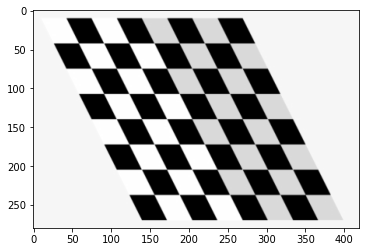

In [3]:
plt.imshow(I) #show image
plt.set_cmap('gray')

### 3. Convolution, Gradients, and Edge Detection
In order to use the Hough transform to detect the linear features in our image we first need to compute and edge map for the image. Although OpenCV does provide a high-level edge detection function, instead we will implement it ourselves using OpenCV 2D convolution function. In particular we will use the well known [Sobel kernels](https://en.wikipedia.org/wiki/Sobel_operator) for approximating the derivatives in the x and y directions. The set of steps involved are shown in the figure below (taken from the course notes): 
<img src="resources/edgedetection.png" width="80%"   style="display: block; margin-left: auto; margin-right: auto;" />

**Task 3:** Complete the code in the cell below by completing each of the following sub-tasks:
1. use the OpenCV function, [`filter2D`](https://docs.opencv.org/4.4.0/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04) with the Sobel kernels to approximate the two gradient images, $\nabla_{x}I(x,y)$ and  $\nabla_{y}I(x,y)$
1. compute the gradient magnitude (as discussed in lectures, see also [https://en.wikipedia.org/wiki/Image_gradient](https://en.wikipedia.org/wiki/Image_gradient)), and finally, 
1. threshold the gradient magnitude to compute the edge map. 
Note: you should manually adjust the threshold level until you find a point at which all the squares of the checkerboard are represented in the edge map. 


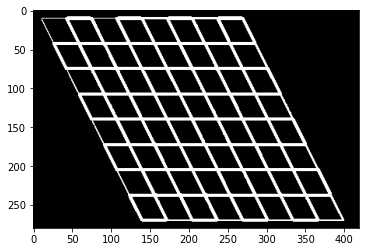

In [4]:
#Define a set of Sobel kernels to compute the gradient in the X-direction and Y-direction
xSobel = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
ySobel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

#TASK 3.1 use cv2.filter2D to estimate the gradients in the X and Y-directions
Ix = cv2.filter2D(I,cv2.CV_64F,xSobel)  #depth must be 64-float as we are computing gradients
Iy = cv2.filter2D(I,cv2.CV_64F,ySobel)

#TASK 3.2 combine the result of TASK 3.2 to compute a gradient magnitude image
G = np.hypot(Ix,Iy)  #np.hypot is efficent method of calculating the square root of Ix_squared + Iy_squared using the pythagoras theorm -> G = sqrt(Ix^2 + Iy^2)

# Here we create an image of equivalent size to G of type uint8 intialised to 0
E = np.zeros(G.shape, dtype='uint8')

#TASK 3.3 Compute an edge-map from G: for each pixel in G above a threshold of 20 set the corresponding pixel in E to 1
low_threshold = 20 
for i in range(0,G.shape[0]):
    for j in range(0,G.shape[1]):
        if(G[i][j] > low_threshold):  #for each pixel greater than the low threshold....
            E[i][j] = True            #set the corresponding pixel point in E to true i.e 1
        else:
            E[i][j] = False           #otherwise set to False i.e 0
plt.imshow(E)
plt.show()   

Notice how some of the edges in edge map are a number of pixels thick. This is due to the use of the (first order) Sobel filter which responds on both side of the image edge, which can result in issue with down stream processing. To ameliorate this problem we can apply a skeletonisation filter which will thin the edges to one-pixel thickness without breaking or shortening the contours. 

Although it is possible to implement skeletonisation in OpenCV, instead we will use an implementation provided by the scikit-image library. The code is provided in the cell below. Notice the output image. 

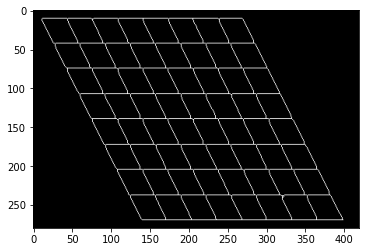

In [5]:
E = skeletonize(E)
plt.imshow(E)
plt.show()

### 3. Detecting lines using the Hough transform

Now that we have a clean edge map for our input image, in this section we will implement and apply the Hough tranform to compute the parameters for each of the lines in the image. The cell below provides a partial definition for a function to compute the Hough tranform where the input to the function consists of: `E`: an edge map; `rho_range`: specifying the minimum, maximum and step size for $\rho$; and `theta_range`: specifying the minimum, maximum, and step size for  $\theta$. The output from the function should be a 2D accumulator array adhering to the resolution specified by `rho_range` and `theta_range`.

The pseudo-code for the Hough transform, as covered during lectures has been broken into tasks within the cell which you should complete by implementing the corresponding steps in python.

**Tips:**
- You should carry out the implementation in 3 steps. First complete the code to define and initiliase the Accumulator array. Next implement the for loops to perform the raster scan of the image. Finally implement the check for an edge pixel and the Hough transform itself. 
- It is possible to implement the Hough transform step without for loops which will make your implementation much more efficient

In [6]:
def Hough(E, rho_range, theta_range):
    '''E - edge image
    rho_range = [rho_min, rho_max, rho_delta]
    theta_range = [theta_min, theta_max, theta_delta]
    '''  
    #TASK 4 Define and initialise the Accumulator array
    acc = np.empty([400,180]) #initilise to the maximum size i.e rho_max x theta_max
    
    #TASK 4.1 use np.arange to create an explicit list of theta values (i.e. [theta_min,theta_min + theta_delta,theta_min + 2*theta_delta, ... ])
    theta_list = np.arange(theta_range[0],theta_range[1],theta_range[2])
    theta_len = len(theta_list)
    
    #TASK 4.2 use np.arange to create an explicit list of rho values (i.e. [rho_min, rho_min + rho_delta, rho_min + 2*rho_delta, ... ])
    rho_list = np.arange(rho_range[0],rho_range[1],rho_range[2])  
    rho_len = len(rho_list)

    # Construct Accumulator
    #TASK 4.3 use np.zeros to create an accumulator array of the correct dimension
    acc = np.zeros((rho_len,theta_len), dtype=np.uint8)
    
    #TASK 5 Write a set of nested for loops to raster scan through the edge image
    for x in range(0,E.shape[0]):       #both x and y will raster scan the image to look for a potential edge point
        for y in range(0,E.shape[1]):
            
            #TASK 6 add an if statment to check if we are at an edge
            if(E[x][y] == True):  #if the current x,y point in E is equal to True (as we set in Task 3.3) then proceed to calculate rho below
                
                #TASK 6.1 Perform the Hough transform by calculating the rho values for each of the theta values
                for t_idx in range(theta_len):
                    cos_t = np.cos(theta_list)     #computes the cos of the theta_list array in one line 
                    sin_t = np.sin(theta_list)     #computes the sin of the theta_list array in one line 
                    rho = np.array((y * cos_t[t_idx]) + (x * sin_t[t_idx])) #for each x, y value between 0-180 (theta values), compute rho

                    #TASK 6.2 map each rho value to its corresponding index in the accumulator array
                    indices = np.divide(rho-rho_range[0],rho_range[2]) #the indices calculation will compute the offset between rho and rho_min: (rho-rho_min)/rho_delta
                    rho_indices = [round(indices),t_idx]               #the indices result is passed in and mapped against the corresponding index in the accumulator array
        
                    #TASK 6.3 use np.logical_and to compute a mask array for valid values in rho_indices
                    mask = np.logical_and(rho_indices[0]>0, rho_indices[0]<400) #check if there are values that exist when rho_indices is greater than 0 and less than 400.. this will stop any overflowing values
                    if(mask == True):                                           #if the values are true then...
                        mask = np.array(rho_indices[0])                         #allow it to be passed in
                        mask = np.array([mask])
                        theta_indices = np.arange(0,mask.shape[0])

                    # TASK 6.4 Add code below to use the rho_indices, theta_indices, and mask array's to index into Acc
                    # and thereby increment all of the points on the sinusoid for the current edge point
                    acc[mask, t_idx] += 1   #only mask values are passed in as they have passed the boundary/overflowing test
    return acc 

#### 3.2 Compute Hough transform

Using the `Hough` function compute the Hough transform of the edge map, `E`, using the following parameters:
- $\rho = -400 \dots 400$ in steps of $\rho_{\Delta} = 2$
- $\theta = 0 \dots \pi$ in steps of $\theta_{\Delta} = \frac{\pi}{180}$

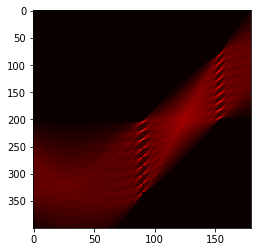

In [7]:
#TASK 7.1 use np.array to define an array containing [rho_min, rho_max, rho_delta]
rho_range = [-400, 400, 2]

#TASK 7.2 use np.array to define an array containing [theta_min, theta_max, theta_delta]
theta_range = [0, np.pi,(np.pi)/180]

#TASK 7.3 add code to compute the Hough transform using the above rho and theta ranges
A = Hough(E, rho_range, theta_range)

plt.imshow(A)
plt.set_cmap('hot')
plt.gca().set_aspect(A.shape[1]/A.shape[0])

In this instance we could simply threshold the resultant accumulator array to identify the peaks in Hough space, often we will first post-process the array to compensate for quantisation effects. Here, numerical rounding results in peaks being distributed around neighbour cells. When thresholding this can cause multiple neighbouring points to be identified as peaks. 

To reduce the effect of this problem a common step is to apply non-maxima suppression. This requires iterating through the array and setting all points to zero if they are not greater than all other points in their neighbourhood.

The function below takes as input a matrix `A` and a window size (`size`) over which the non-maxima suppression is applied. **Note** that you can assume that the non-maxima suppression is only applied in areas where the neighbourhood is defined. 

Replace the comments in the inner part of the nested `for`-loop with code to compute the appropriate output value for `M[row,col]` based on the non-maxima suppresion algorithm.


In [8]:
def nonmax(A, size = 1):
    M = np.zeros(A.shape)
    for col in range(size,A.shape[1]-size):
        for row in range(size,A.shape[0]-size):
            #TASK 8: Add code to copy the value of A[row,col] through to M[row,col] iff it is greater than all of the the *other* values
            # in the neighbour from [row-size, col-size] to [row+size, col+size]
            if(A[row,col] == np.max(A[row-size:row+size, col-size:col+size])): #Need to compare the neighbourhood of points in the accumulator array by computing the max value...
                M[row,col] = A[row,col]                                        #and then comparing that to the current value at the center, copy the point over to M
            else:
                M[row,col] = 0                                                 #otherwise we set to 0
    return M

The following code applies our non-maxima algorithm to the accumulator array based on a 11x11 window, and then displays the result (in a square aspect ratio).

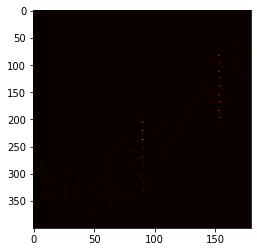

In [9]:
A = nonmax(A,5)
plt.imshow(A)
plt.gca().set_aspect(A.shape[1]/A.shape[0])

Next, the code below provides method for extracting the $(\rho, \theta)$-values for each value above a given threshold. The reason that we need this is that the we need to both identify the [row,col] indices of the values that exceed the threshold, and, to map these indices to their corresponding $(\rho, \theta)$-values.

In [10]:
def extract_peaks(A, thresh, r_range, theta_range):
    ind = np.where(A>thresh)
    theta_list = np.arange(theta_range[0], theta_range[1], theta_range[2])
    r_list = np.arange(r_range[0], r_range[1], r_range[2])
    
    return (r_list[ind[0]], theta_list[ind[1]])

The next function, based on the drawing code from the OpenCV tutorials, takes an image and a $(\rho, \theta)$ pair and draws the corresponding line on the image 

In [11]:
def drawline(img, r, theta):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*r
    y0 = b*r
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(img,(x1,y1),(x2,y2),(255,0,255),2)

Using the `extract_peaks` and `drawline` methods above complete the code below by replacing the comments with the appropriate calls.

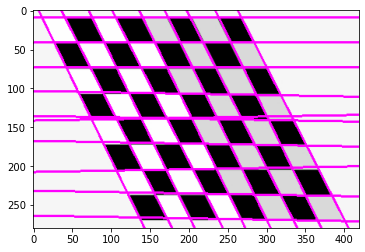

In [12]:
#TASK 9: Use the extract_peaks function to find all peaks greater than a value of 170
rs, ps = extract_peaks(A,120,rho_range,theta_range) #correct
D = Ic.copy()

#TASK 10: Add code to use drawline to visualise each detected line on the image D
length = len(rs)             #calculate total number of points (or even pairs of points if to include ps)
for i in range(0,length):    #draw the line for each point as the 'i' counter increments
    drawline(D,rs[i],ps[i])  

# show the resultant lines
plt.imshow(D)
plt.show()

Finally, the following function takes two lines specified by their $(\rho, \theta)$-parameters and computes and returns their point of intersection.

In [13]:
def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.

    Returns closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    try:
        x0, y0 = np.linalg.solve(A, b)
    except:
        print("Singular matrix -- You should check that the lines are not close to parallel"
              "e.g. check that lines are not within 10 degrees of each other")
        raise
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]

Complete the code below to populate the `intersections` list with the the intersections of the horizontal and (near) vertical lines. **Note that you should avoid calling the `intersection` function on pairs of lines that are close to parallel since it will raise an exception due a singular matrix. Hence you should check that any lines are not withing e.g. 10 degrees of parallel prior to calling this function.**

In [14]:
intersections = []
vertical = []
horizontal = []

# TASK 11: Add code here that uses the intersection function to compute the intersection
# between each pair of detected lines, where the angle between the lines is greater than
# 10 degree (i.e. np.pi/18 radians). Each intersection should be appended to the 
# intersections list
vertical_line_end_position = 9                           #there are a total of 9 vertical lines
for i in range(0,vertical_line_end_position):                  
    vertical.append([rs[i],ps[i]])                       #firstly seperate the vertical lines into one array (vertical)

for i in range(vertical_line_end_position,length):
    horizontal.append([rs[i],ps[i]])                     #secondly seperaate the horizontal lines into another array (horizontal)
    
for i in range(0,vertical_line_end_position):            #for each vertical line and
    for j in range(0,length-vertical_line_end_position): #for each horizontal line
        line1 = vertical[i]                              #line1 becomes the vertical lines
        line2 = horizontal[j]                            #line2 becomes the horizontal lines
        [[x0,y0]] = intersection(line1,line2)            #call the intersection function and.....
        intersections.append([[x0,y0]])                  #append the results to the array
    

As a last step, you can validate your code to calculate the intersections by visualising them using the codeblock below.

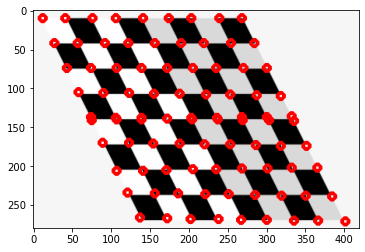

In [15]:
D = Ic.copy()
i = 0
for i in intersections:
    cv2.circle(D,(i[0][0],i[0][1]),4,(255,0,0),thickness=3)  
plt.imshow(D)
plt.show()